In [9]:
# pip install numpy
# pip install pandas
# pip install healpy
# pip install matplotlib

In [1]:
import numpy as np
import pandas as pd

import healpy as hp

import matplotlib.pyplot as plt
%matplotlib inline 
#show graph inside the notebook

from astropy.io import fits

In [2]:
from astropy.io import fits
hfi = fits.open("HFI_RIMO_R3.00.fits")

In [3]:
hfi.info()

Filename: HFI_RIMO_R3.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  HFI_RIMO      1 PrimaryHDU      14   ()      
  1  MAP_PARAMS    1 BinTableHDU     50   6R x 10C   [3A, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  2  BANDPASS_F100    1 BinTableHDU     28   12297R x 3C   [1E, 1E, 1A]   
  3  BANDPASS_F100    1 BinTableHDU     28   12297R x 3C   [1E, 1E, 1A]   
  4  BANDPASS_F143    1 BinTableHDU     28   12602R x 3C   [1E, 1E, 1A]   
  5  BANDPASS_F217    1 BinTableHDU     28   12600R x 3C   [1E, 1E, 1A]   
  6  BANDPASS_F353    1 BinTableHDU     28   12930R x 3C   [1E, 1E, 1A]   
  7  BANDPASS_F545    1 BinTableHDU     28   13938R x 3C   [1E, 1E, 1A]   
  8  BANDPASS_F857    1 BinTableHDU     28   16819R x 3C   [1E, 1E, 1A]   
  9  BANDPASS_PSB353    1 BinTableHDU     28   12930R x 3C   [1E, 1E, 1A]   


Filename: HFI_RIMO_R3.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  HFI_RIMO      1 PrimaryHDU      14   ()      
  1  MAP_PARAMS    1 BinTableHDU     50   6R x 10C   [3A, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  2  BANDPASS_F100    1 BinTableHDU     28   12297R x 3C   [1E, 1E, 1A]   
  3  BANDPASS_F100    1 BinTableHDU     28   12297R x 3C   [1E, 1E, 1A]   
  4  BANDPASS_F143    1 BinTableHDU     28   12602R x 3C   [1E, 1E, 1A]   
  5  BANDPASS_F217    1 BinTableHDU     28   12600R x 3C   [1E, 1E, 1A]   
  6  BANDPASS_F353    1 BinTableHDU     28   12930R x 3C   [1E, 1E, 1A]   
  7  BANDPASS_F545    1 BinTableHDU     28   13938R x 3C   [1E, 1E, 1A]   
  8  BANDPASS_F857    1 BinTableHDU     28   16819R x 3C   [1E, 1E, 1A]   
  9  BANDPASS_PSB353    1 BinTableHDU     28   12930R x 3C   [1E, 1E, 1A]   
['WAVENUMBER', 'TRANSMISSION', 'FLAG']


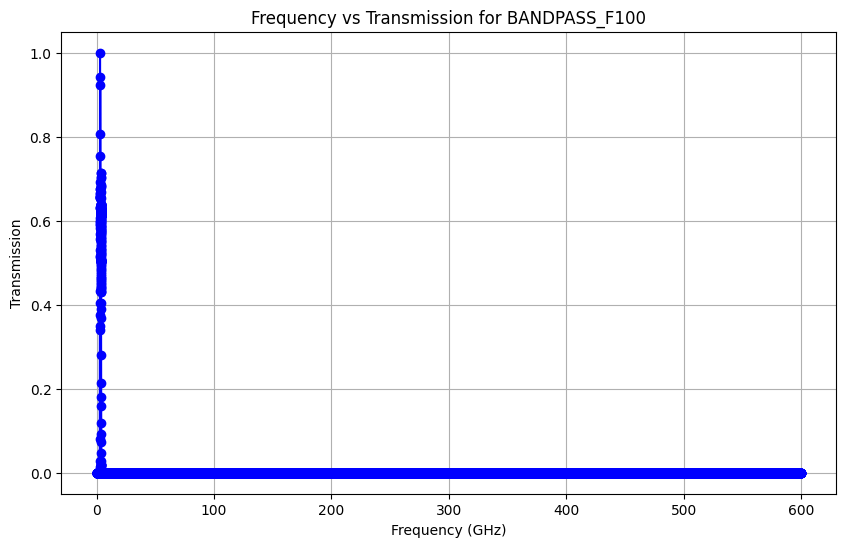

In [10]:
from astropy.io import fits
import matplotlib.pyplot as plt

# Open the FITS file
hfi = fits.open("HFI_RIMO_R3.00.fits")

# Inspect the contents
hfi.info()

# Extract data from the BANDPASS_F100 extension
data = hfi[2].data  # BANDPASS_F100 is in the 2nd extension
header = hfi[2].header

# Print column names to understand the structure
print(data.columns.names)

# Assuming the data has columns 'WAVELENGTH' and 'TRANSMISSION'
# Replace these with the actual column names from the FITS file
# Here, let's assume the columns are ['FREQUENCY', 'TRANSMISSION', 'NAME'] as an example
x = data['WAVENUMBER']  # Replace 'col1' with the actual column name for the first column
y = data['TRANSMISSION']  # Replace 'col2' with the actual column name for the second column

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b')
plt.xlabel('Frequency (GHz)')  # Replace with an appropriate label
plt.ylabel('Transmission')  # Replace with an appropriate label
plt.title('Frequency vs Transmission for BANDPASS_F100')
plt.grid(True)
plt.show()

# Close the FITS file
hfi.close()

In [ ]:
#!/usr/bin/env python
print('IN')
import os
if 'SLURM_JOBID' in os.environ:
    import matplotlib
    matplotlib.use('PDF')
import os.path as op
import parameter_estimation as pe
import pickle as pkl
import argparse
import numpy as np
import sys
from astropy.io import fits
#from pysm import convert_units
import pysm3.units as u

def _cmb2jysr(freqs):
    return (np.ones_like(freqs) * u.K_CMB).to(
        u.Jy / u.sr, equivalencies=u.cmb_equivalencies(freqs * u.GHz)).value

PB_BANDPASS = '/global/project/projectdirs/polar/data/largepatch_planck_sim_set/bandpasses_for_davide/pb_design_band.txt'
HFI_BANDPASS = '/global/project/projectdirs/polar/data/largepatch_planck_sim_set/bandpasses_for_davide/HFI_RIMO_R3.00.fits'

FULL_ELL_RANGE = True

spectra_keys = ['tt', 'ee', 'bb', 'te', 'tb', 'eb']

class _LoadBinEdges(argparse.Action):
    def __call__(self, parser, namespace, value, option_string=None):
        bins = pkl.load(open(value,'rb'))['bins']
        bins = np.unique(bins)
        setattr(namespace, self.dest, bins)
pe._LoadBinEdges = _LoadBinEdges


class _LoadFrequencies(argparse.Action):
    def __call__(self, parser, namespace, value, option_string=None):
        bandpasses = []
        with fits.open(HFI_BANDPASS) as heads:
            for freq in '143 150 217 353'.split():
                if freq == '150':
                    f, t = np.loadtxt(PB_BANDPASS).T
                    f *= 1e-9
                else:
                    f = heads['BANDPASS_F%s'%freq].data.field('WAVENUMBER')
                    t = heads['BANDPASS_F%s'%freq].data.field('TRANSMISSION')
                    f *= 1e-7 * 3e8
                mask = t > 1e-2
                f = f[mask]
                t = t[mask]
                #breakpoint()
                t *= _cmb2jysr(f.astype(np.float64))
                #t *= convert_units('K_CMB', 'Jysr', f)
                t /= np.trapz(t, f)
                bandpasses.append(np.array((f, t)))

        #import pylab as pl
        #for f, t in bandpasses:
            #print(len(f))
            #pl.plot(f, t)
        #pl.show()
        setattr(namespace, self.dest, bandpasses)



#         import pylab as pl
#         for f, t in bandpasses:
#             print(len(f))
#             pl.plot(f, t)
#         pl.show()
        setattr(namespace, self.dest, bandpasses)


class _LoadDOF(argparse.Action):
    def __call__(self, parser, namespace, value, option_string=None):
        try:
            float(value)
        except ValueError:
            dof_file = pkl.load(open(value, 'rb'))
            dof = [dof_file[key]['nub'] for key in spectra_keys]
            setattr(namespace, self.dest, dof)  # AB spectrum file
        else:
            setattr(namespace, self.dest, value)  # float (fsky)
pe._LoadDOF = _LoadDOF


class _LoadSpectra(argparse.Action):
    def load_file(self, filename):
        spec_file = pkl.load(open(filename,'rb'))
        return [spec_file[key]['Cb'] * 1e12 for key in spectra_keys] # * 1e12

    def __call__(self, parser, namespace, values, option_string=None):
        if isinstance(values, list):
            setattr(namespace, self.dest,
                    [self.load_file(v) for v in values])
        else:
            setattr(namespace, self.dest, self.load_file(values))
pe._LoadSpectra = _LoadSpectra


def run(tag, pb_factor=None):
    ''' tag = comp1__comp2__comp3___seed
    '''
    print(tag)
    #ROOT = '/project/projectdirs/polar/data/largepatch_planck_sim_set'
    ROOT = 'polar'
    # DOF are always abscal, also for sims
    PB_DOF = 'polar/dof/calculated/pb/allspec.pkl'
    #PB_DOF = 'polar/dof/calculated/pb/allspec.pkl'
    DOF = 'polar/dof/calculated/planck_pb_final/allspec.pkl'
    PLANCK_DOF = 'polar/dof/calculated/planck/allspec.pkl'

    # Fit parmas
    model = 'cross_cmb_dust'
    if 'cmb' in tag:
        r_tag = tag.split('_')[1]
        if 'dust' in tag:
            fit_for = 'r A_dust alpha_dust beta_dust'
            if 'data' in tag:
                param0 = '%s 4.6 -0.58 1.59' % (r_tag[1:].replace('p', '.')+'1')
            else:
                param0 = '%s 4.45 -0.3 1.59' % (r_tag[1:].replace('p', '.')+'1')
        else:
            fit_for = 'r'
            param0 = r_tag[1:].replace('p', '.')+'1'

    else:
        fit_for = 'A_dust alpha_dust beta_dust'
        param0 = '4.6 -0.3 1.59'
    seed = tag.split('___')[1]

    # Freqs
    freqs = ['planck_143', 'pb', 'planck_217', 'planck_353']
    freq_tags = []
    for freq1 in freqs:
        for freq2 in freqs:
            if freq1 == freq2:
                freq_tags.append(freq1)
            elif freq2 == 'pb':
                freq_tags.append(freq1+'_pb')
            elif freq1 == 'pb':
                freq_tags.append(freq2+'_pb')
            else:
                freq_tags.append('%s_%s'%(min(freq1, freq2), max(freq1, freq2)))

    # Folders
    pe._LoadFrequencies = pe._StoreArray
    if 'data' in tag:
        components = 'real_spectra_abscal'
        pe._LoadFrequencies = _LoadFrequencies
    elif 'noise' in tag:
        if 'cmb' in tag and 'dust' in tag:
            components = 'sum_%s_spectra_fid' % r_tag
        elif 'cmb' in tag:
            components = 'cmb_noise_%s_spectra_fid' % r_tag
        elif 'dust' in tag:
            components = 'dust_noise_spectra_fid'

    elif 'dust' in tag:
        if 'cmb' in tag:
            components = 'combined_%s_spectra_fid' % r_tag
        else:
            components = 'dust_spectra_fid'
    else:
        components = 'cmb_%s_spectra_fid' % r_tag

    components += '_pb_fakeauto'

    # Inputs
    cmb_dust_noise, seed = tag.split('___')
    if 'data' in seed:
        inputs = []
        for freq_tag in freq_tags:
            inputs.append(op.join(ROOT, components, freq_tag,
                                  'allspec.pkl'))
    else:
        inputs = [
            op.join( ROOT, components, seed, freq_tag, 'allspec.pkl')
            for freq_tag in freq_tags]

    # Output
    outdir_extra = ''
    if FULL_ELL_RANGE:
        outdir = op.join('workspace', 'comp_sep', cmb_dust_noise, seed+outdir_extra)
        ell_range = ' --ell_range 50 600'
    else:
        outdir = op.join('workspace', 'comp_sep_199', cmb_dust_noise, seed)
        ell_range = ' --ell_range 50 199'

    print(model, fit_for, param0, outdir)
    if 'gm_dof' in tag:
        dof_file = DOF
    if 'pb_dof' in tag:
        dof_file = PB_DOF
    if 'planck_dof' in tag:
        dof_file = PLANCK_DOF

    args_str = (
    ' --bin_edges ' + inputs[0] +
    ' --out_dir ' + outdir +
    ' --spectra BB' +
    ell_range +
    ' --input ' + ' '.join(inputs) +
    ' --dof ' + dof_file +
    ' --fit_for ' + fit_for +
    ' --param0 ' + param0 +
    ' --mc_n_step 500000'
    ' --overwrite '
    #' --test '  #XXX
    #' --show '
    #' --no_prior '
    + model +
    ' --freqs 143 150 217 353 '
    )
    
    if False:
        args_str = (' --pb_noise_bias ') + args_str

    if 'dust' in model:
        args_str += ' --dust_ell0 80 --dust_freq0 353 --dust_temp 19.6 '
        dust_tag = tag.split('__')[1]
        if 'prior' in dust_tag and 'beta' in dust_tag:
            args_str += ' --beta_prior 0.11 '  # Extracted from Fig 4 of BK15
        if 'prior' in dust_tag and 'alpha' in dust_tag:
            args_str += ' --alpha_prior 0.21 '  # Extracted from Fig 4 of BK15

    if 'noise' in tag:
        inter_path = 'noise_bias'
        args_str = (
            ' --n_ell %s %s' %
            (' '.join(['polar/%s/%s/allspec.pkl'%(inter_path, f)
                       for f in freqs]),
             args_str))

    #sys.stdout = open(op.join(outdir, 'log'), 'w')
    args_list = args_str.split()
    parser = pe.get_parser()
    try:
        print (args_list)
        args = parser.parse_args(args_list)
    except SystemExit as err:
        print ('\nIf you get some unexpected parsing error, try \n'
               '- putting the model-specific arguments at the end \n'
               '- putting a flag with fixed number of arguments right before '
               'the model name (e.g. mc_n_step)')
        raise err

    pe.main(args)

if __name__ == '__main__':

    seeds = ['sim%03d' % i for i in range(96)] + ['data']
    cmbs = ['cmb_r0p%i0' % i for i in range(1)]
    extras = ['__noise', '__dust_prior_beta__noise', '__dust_prior_beta_alpha__noise']
    extras = ['__dust_prior_beta_alpha__noise']
    extras = [e+t for e in extras for t in ['__planck_dof', '__pb_dof', '']]
    try:
        i = int(sys.argv[1])
    except IndexError:
        pass
    else:
        extras = extras[i::3]
    tags = [cmb + extra + '___' + seed
            for cmb in cmbs for extra in extras for seed in seeds]
    print('N runs', len(tags))

    rank = 0
    n_proc = 1
    if 'SLURM_JOBID' in os.environ:
        from mpi4py import MPI
        comm = MPI.COMM_WORLD
        rank = comm.rank
        n_proc = comm.size
        print ('%i/%i ready'%(rank, n_proc-1))
    else:
        import healpy as hp
        import matplotlib.pyplot as plt

    #run(f"cmb_r0p00__dust_prior_beta_alpha__noise__gm_dof___sim{rank:03}")
    run(f"cmb_r0p00__dust_prior_beta_alpha__noise__gm_dof___data")

In [18]:
PLA_Data = pd.read_csv("data/planck_simulation/PLA-Results.csv")

# Store the names of the datasets into PLA_Data_List
PLA_Data_List = PLA_Data['SIMULATED_MAP.FILE_ID'].to_list()


# Initialize PLA_Data_Dict : (key:frequnecy, value: [csv path])
PLA_Data_Dict = dict()
for each_csv_path in PLA_Data_List:
    PLA_Data_Dict[each_csv_path[20:23]] = ["data/planck_simulation/"+each_csv_path]
# display(PLA_Data_Dict)

# Read the CMB datasets and store them inside the PLA_Data_Dict
# Update PLA_Data_Dict : (key:frequnecy, value: [csv path, hp map dat ])
 
for frequency, storage_list in PLA_Data_Dict.items():
    storage_list.append(hp.read_map(storage_list[0]))
# display(PLA_Data_Dict)

# Convert the unit from unitMJy/steradian to K_CMB
# Source: https://wiki.cosmos.esa.int/planckpla2015/index.php/UC_CC_Tables

PLA_Data_Dict["545"][1] = PLA_Data_Dict["545"][1]/58.0356
PLA_Data_Dict["857"][1] = PLA_Data_Dict["857"][1]/2.2681

In [1]:
# Convert the unit from unitMJy/steradian to K_CMB
# Source: https://wiki.cosmos.esa.int/planckpla2015/index.php/UC_CC_Tables

# from IPython.display import Image
# Image("graphs/unit.png",width = "900",height = "900")

from IPython.display import Image
Image("https://wiki.cosmos.esa.int/planckpla2015/index.php/UC_CC_Tables",width = "900",height = "900")


ValueError: Cannot embed the 'https://wiki.cosmos.esa.int/planckpla2015/index.php/uc_cc_tables' image format

In [50]:
hp.get_nside(PLA_Data_Dict["030"][1])

1024

In [33]:
print("30:", PLA_Data_Dict["030"][1])
print("353:", PLA_Data_Dict["353"][1])
print("545:", PLA_Data_Dict["545"][1])
print("857:", PLA_Data_Dict["857"][1])

30: [-2.7133717e-04 -9.3698480e-05 -2.5107505e-04 ... -1.5273600e-04
 -1.1094811e-04 -7.7221979e-05]
353: [ 2.5032787e-06 -4.4501619e-05  3.3136457e-05 ... -4.4852728e-05
 -1.9124709e-05  2.4272595e-05]
545: [0.01128773 0.0130048  0.01321571 ... 0.00584028 0.00529944 0.00489832]
857: [0.5111374  0.5519411  0.5755057  ... 0.43332872 0.45767516 0.44152597]


In [1]:
# PLA_Data_Dict["030"][1]

/var/folders/40/1xzzgj3j5mb151czz5zshmrw0000gn/T/ipykernel_10263/1361267249.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


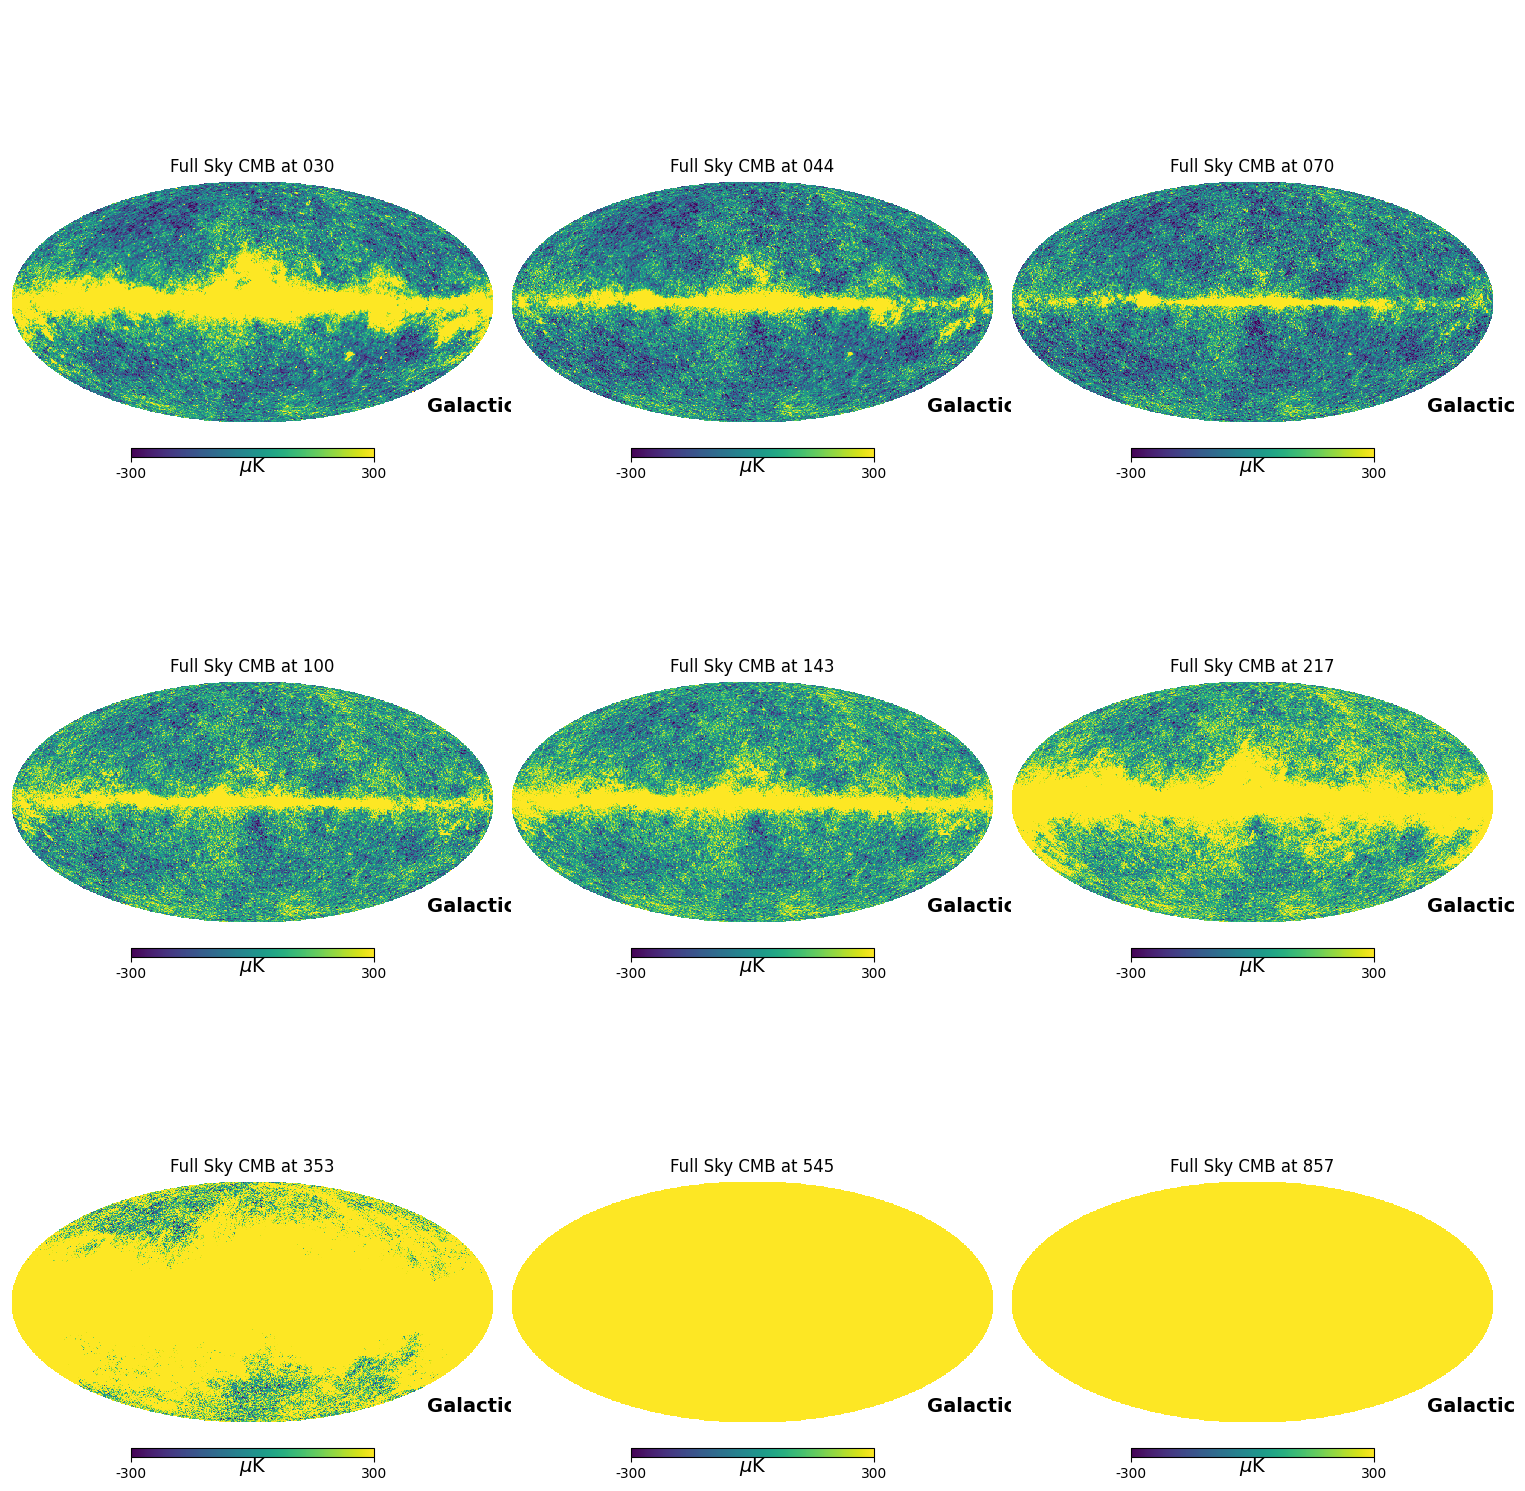

In [4]:
frequencies = PLA_Data_Dict.keys()

# Create a figure with a 3x3 grid of subplots
fig = plt.figure(figsize=(15, 15))

# n = 1
# Iterate over frequencies and corresponding axes
for i, frequency in enumerate(frequencies, start=1):

    # n = n*1.2
    # Create a subplot for the current frequency
    ax = fig.add_subplot(3, 3, i)
    
    # Plot the map for the current frequency
    hp.mollview(
        PLA_Data_Dict[frequency][1]* 1e6,
        coord=["G"],
        title="Full Sky CMB at "+frequency,
        unit=r"$\mu$K",
        # unit="K",
        # norm="hist",
        # min=-1*n,
        # max=1*n,
        min=-300,  
        max=300,
        fig=fig,
        sub=(3, 3, i)  # Specify the subplot position
    )
    ax.axis('off')
    # Add graticule to the map
    # hp.graticule()
    

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()


/var/folders/40/1xzzgj3j5mb151czz5zshmrw0000gn/T/ipykernel_10263/3250676843.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


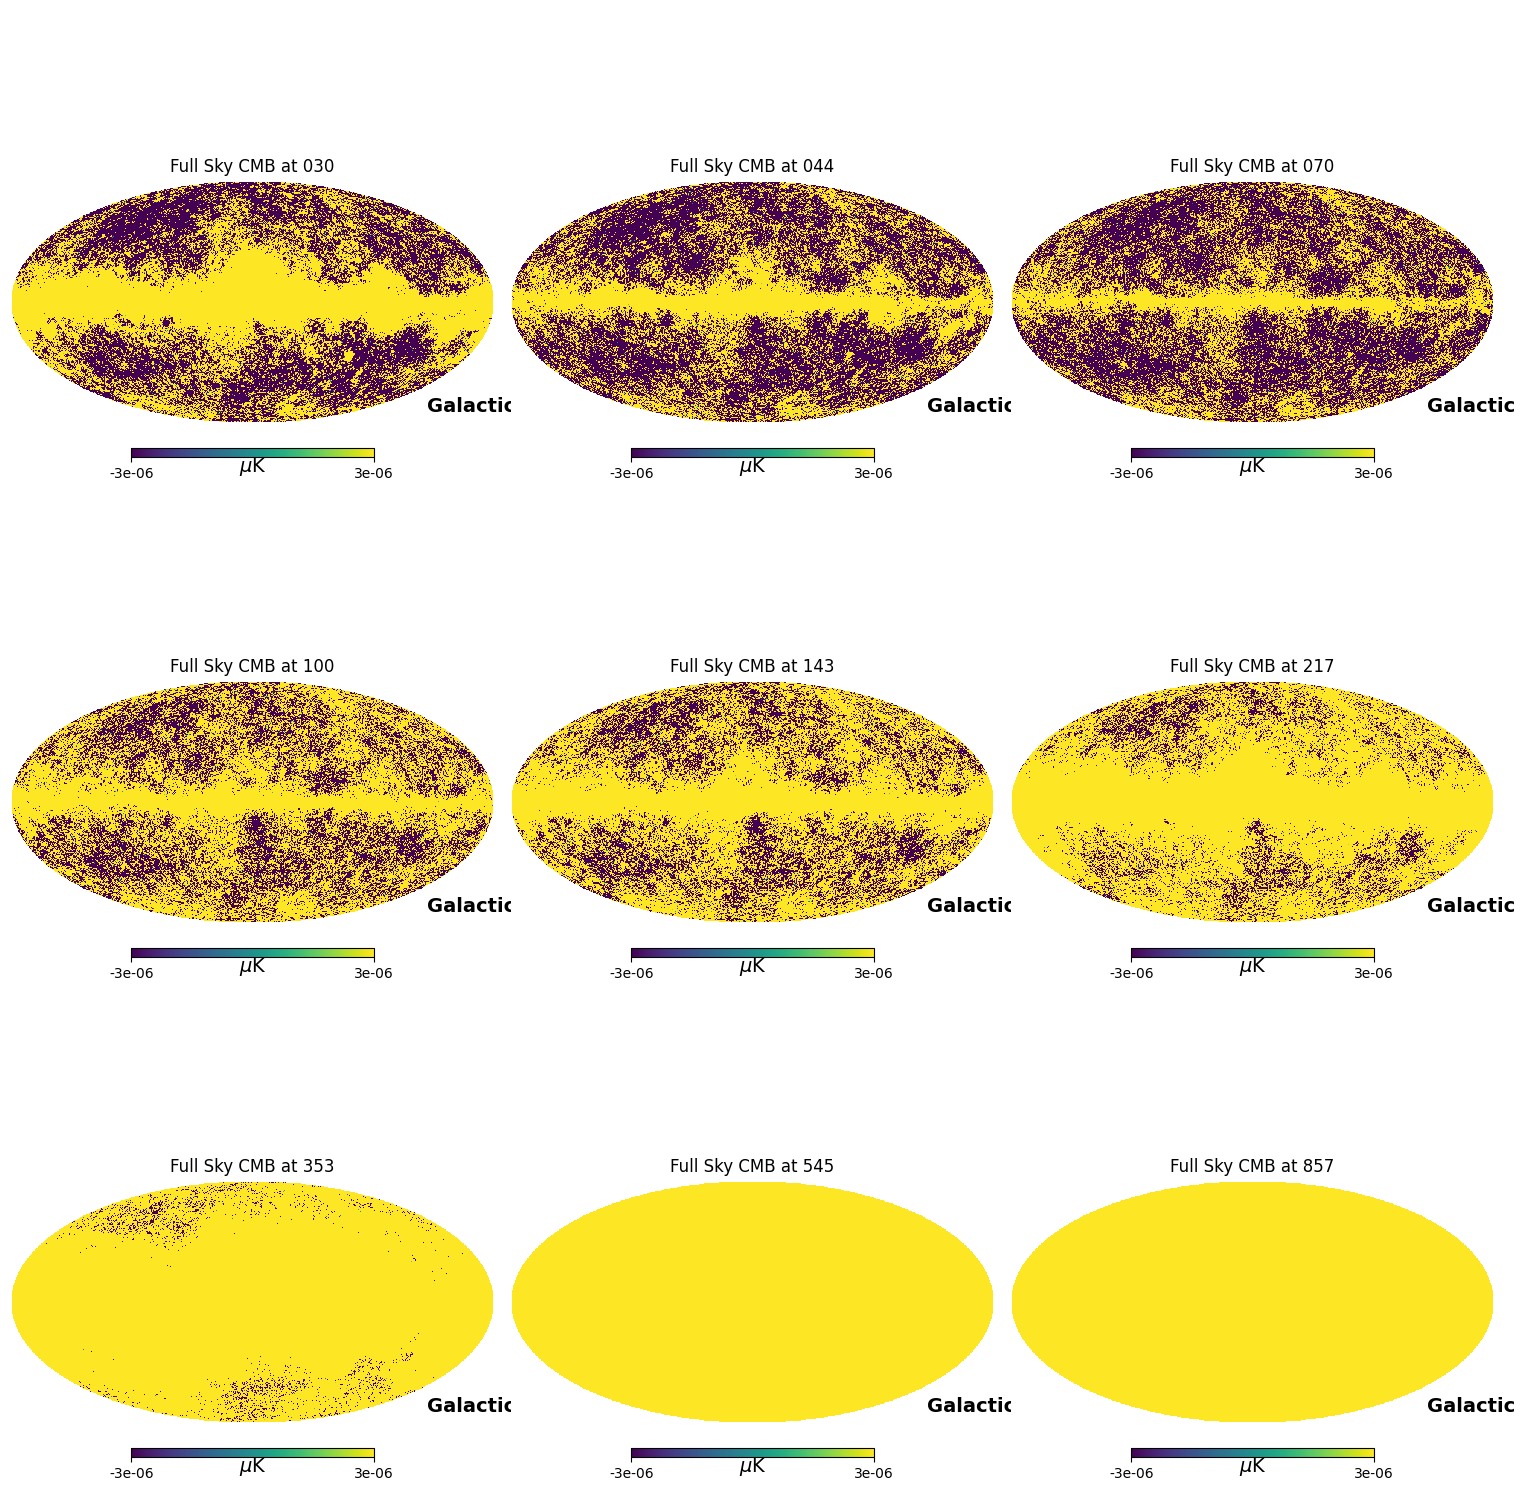

In [14]:
frequencies = PLA_Data_Dict.keys()

# Create a figure with a 3x3 grid of subplots
fig = plt.figure(figsize=(15, 15))

# n = 1
# Iterate over frequencies and corresponding axes
for i, frequency in enumerate(frequencies, start=1):

    # n = n*1.2
    # Create a subplot for the current frequency
    ax = fig.add_subplot(3, 3, i)
    
    # Plot the map for the current frequency
    hp.mollview(
        PLA_Data_Dict[frequency][1],
        coord=["G"],
        title="Full Sky CMB at "+frequency,
        unit=r"$\mu$K",
        # unit="K",
        # norm="hist",
        # min=-1*n,
        # max=1*n,
        min=-3*1e-6, 
        max=3*1e-6,
        fig=fig,
        sub=(3, 3, i)  # Specify the subplot position
    )
    ax.axis('off')
    # Add graticule to the map
    # hp.graticule()
    

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()
